### Preamble

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
import os
from sklearn.preprocessing import MultiLabelBinarizer
import numpy as np
from sklearn.metrics import hamming_loss
import shutil
from IPython.display import display
import importlib
import time
import datetime
import pickle
import helpers

%load_ext autoreload
%autoreload 2

%matplotlib inline

Using TensorFlow backend.


Check if GPU is used for Deep Learning

In [2]:
assert helpers.is_gpu_used()

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 1342445243785099023
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 3211018240
locality {
  bus_id: 1
  links {
  }
}
incarnation: 8203762548499173260
physical_device_desc: "device: 0, name: Quadro M2200, pci bus id: 0000:01:00.0, compute capability: 5.2"
]


In [3]:
posters_dir = os.path.join('data', 'posters')

In [4]:
import ast

def read_movies_data():
    converters = {'relevant_genres': eval, 'tags': eval, 'genres': eval}
    movies = pd.read_csv(os.path.join('data', 'movie_training_data.csv'), index_col='movieId', converters=converters)
    return movies
    
movies = read_movies_data()
display(movies.head(3))
movies.shape

,title,genres,release_year,language,local_poster_file,relevant_genres,tags
movieId,,,,,,,
1,Toy Story (1995),"[Adventure, Animation, Children, Comedy, Fantasy]",1995,en,1.jpg,[Comedy],"[3d, cgi, classic, clever, disney, family, fri..."
3,Grumpier Old Men (1995),"[Comedy, Romance]",1995,en,3.jpg,"[Comedy, Romance]",[sequel]
4,Waiting to Exhale (1995),"[Comedy, Drama, Romance]",1995,en,4.jpg,"[Comedy, Drama, Romance]",[chick flick]


(10649, 7)

Genres and tags are categorical variables. To use them in deep learning they have to be encoded into 1-0-vectors. We can use the MultiLabelBinarizer to do so.

In [5]:
from sklearn.preprocessing import MultiLabelBinarizer
genres_binarizer = MultiLabelBinarizer().fit(movies.relevant_genres)
tags_binarizer = MultiLabelBinarizer().fit(movies.tags)

#def print_tags_binarizer_example():
#    print(movies.loc[1].tags)
#    print(tags_binarizer.transform([movies.loc[1].tags]))
#    
#print_tags_binarizer_example()

### Measuring Training Performance

As suggested in the capstone proposal review, I am going to use the column-wise roc-auc score with macro averaging as my perfromance metric. Additionally it is posssible to deduct the optimal threshold.


In [6]:
from sklearn.metrics import roc_auc_score

def calc_performance_metric(y_true, y_predicted):
    return roc_auc_score(y_true, y_predicted, average='macro')

In [93]:
from sklearn.metrics import roc_curve, accuracy_score

def calc_optimal_thresholds(y_true, y_predicted):
    '''
    :param y_true true labels for a movie set. 
    two dimensional 0-1 numpy array where rows are movies and columns are genres.
    value is 1 if movie has the respective genre.
    
    :param y_predicted predicted probability distributions by the model for the same dataset as in y_true.
   
    :returns: list of optimal thresholds per genre
    '''
    optimal_thresholds = []
    
    for i in range(y_true.shape[1]):
        column_true = y_true[:, i]
        column_predicted = y_predicted[:, i]
        # the roc_curve implementation returns all thresholds where tpr or fpr change
        # I will compute for each threshold what the accuracy is and choose
        # the threshold with the highest accuracy.
        fpr, tpr, thresholds = roc_curve(column_true, column_predicted)
        
        def calc_accuracy(threshold):
            genres_present = (column_predicted >= threshold).astype(int)
            return accuracy_score(column_true, genres_present)
        
        # calc accuracy for each genre
        accuracies = list(map(calc_accuracy, thresholds))
        optimal_threshold_idx = np.argmax(accuracies)
        optimal_threshold = thresholds[optimal_threshold_idx]
        optimal_thresholds.append(optimal_threshold)
        
    return optimal_thresholds

def calc_mean_accuracy(y_true, y_predicted_values, thresholds):
    '''
    :param y_true true labels for a movie set. 
    
    :param y_predicted_values predicted probability distributions by the model for the same dataset as in y_true.
    
    :param thresholds list of thresholds per genre. If predicted value is above threshold the movie 
    is predicted be of the genre, and not otherwise
    
    :returns: mean value of the accuracy for each genre.
    '''
    y_predicted = np.zeros(y_true.shape)
    for column in range(y_true.shape[1]):
        # for each genre compute if the genre is predicted or not predicted.
        y_predicted[:, column] = (y_predicted_values[:, column] >= thresholds[column]).astype(int)
    
    return np.mean([accuracy_score(y_true[:, col], y_predicted[:, col]) for col in range(y_true.shape[1])])

### TEST CODE ####
assert 0.75 == calc_mean_accuracy(np.array([[1, 1], [0, 1]]), np.array([[1, 1], [1, 1]]), [.5, .5])

def test_optimal_thresholds_calc():
    optimal_thresholds = calc_optimal_thresholds(np.array([[1], [0]]), np.array([[0.61], [0.59]]))
    assert len(optimal_thresholds) == 1, 'Len: {}'.format(len(optimal_thresholds))
    assert 0.59 < optimal_thresholds[0] <= 0.61 , str(optimal_thresholds)
    
test_optimal_thresholds_calc()
###############################

In [94]:
# Method that summarizes column-wise roc-auc, computation of the optimal thresholds and the mean accuracy metric.
def calc_metrics(labels, predictions):
    performance_metric = calc_performance_metric(labels, predictions)
    optimal_thresholds = calc_optimal_thresholds(labels, predictions)
    mean_accuracy = calc_mean_accuracy(labels, predictions, optimal_thresholds)
    return performance_metric, optimal_thresholds, mean_accuracy

### 

In [95]:
X_train, X_validation = train_test_split(movies, test_size=0.1, random_state=1)
X_train, X_test = train_test_split(X_train, test_size=0.1, random_state=1)

In [96]:
def batch_generator(dataframe, config, distortion=False, batch_size=20):
    '''
    :param dataframe movies dataset encoded as a pandas dataframe
    :param config dictionary that provides parameters for 
    '''
    
    img_width, img_height = config['img_size']
    
    train_datagen = ImageDataGenerator(
        rescale=1./255,
#         shear_range=0.2,
#         zoom_range=0.2,
#         horizontal_flip=False
    )   
    
    #randomize the rows of the dataframe
    row_generator = dataframe.sample(frac=1).iterrows()
    
    for batch_count in range(int(dataframe.shape[0]/batch_size)):
        
        batch = {
            'images_encoded': [], # encoded movie posters
            'image_files': [], # file names of the movie posters
            'genres': [], 
            'genres_encoded': [], # multi label encodings of the genres
            'tags': [],
            'tags_encoded': [], # multi label encodings of the tags
        }
        
        for img_count in range(batch_size):
            _, row = next(row_generator)
            
            # Movie poster encoding
            img_path = os.path.join(posters_dir, row['local_poster_file'])
            img = load_img(img_path, target_size=(img_width, img_height))
            img = img_to_array(img)
            if hasattr(img, 'close'):
                img.close()
            if distortion:
                img = train_datagen.random_transform(img)
            img = train_datagen.standardize(img)
            ###########

            batch['images_encoded'].append(img)
            batch['image_files'].append(row['local_poster_file'])
            batch['genres'].append(row['relevant_genres'])
            batch['genres_encoded'].append(genres_binarizer.transform([row['relevant_genres']])[0])
            batch['tags'].append(row['tags'])
            batch['tags_encoded'].append(tags_binarizer.transform([row['tags']])[0])
        
        # wrap the data used for deep learning as numpy arrays
        batch['images_encoded'] = np.array(batch['images_encoded'])
        batch['genres_encoded'] = np.array(batch['genres_encoded'])
        batch['tags_encoded'] = np.array(batch['tags_encoded'])
        
        yield batch
            
    return

#print(X_train.shape)
#next(batch_generator(X_train))

In [97]:
# calc trivial model metrics
def calc_trivial_model_metrics():
    data = X_test
    config = {'img_classifier_architecture': None, 'model_type': None, 'img_size': (224, 224)}
    batch = next(batch_generator(data, config, batch_size=data.shape[0], distortion=False))
    predictions = np.repeat(genres_binarizer.transform([['Drama',]]), data.shape[0], axis=0)
    return calc_metrics(batch['genres_encoded'], predictions)

calc_trivial_model_metrics()

(0.5, [1, 1, 1, 1, 2, 1, 1, 1], 0.7917101147028155)

### Models

In [98]:
from keras.models import Sequential, Model, Input
from keras.layers import Dropout, Flatten, Dense, GlobalAveragePooling2D
from keras import applications
from keras import optimizers
from keras.layers import concatenate
from enum import Enum
from keras.engine.topology import Layer

def create_tag_and_image_model(config):
    # Retrieve image classification architecture, i.e. VGG16 or InceptionV3 should be used and the image width 
    # and height to be able to define the Input object
    img_classifier_architecture = config['img_classifier_architecture']
    img_width, img_height = config['img_size']
    
    # To be able to map from batch object to the input one needs a named Input object
    image_input = Input(shape=(img_width, img_height, 3) , name='images_encoded')

    # Load VGG16 or InceptionV3 network architecture and weights
    if img_classifier_architecture == 'VGG16':
        base_model = applications.VGG16(include_top=False, weights='imagenet', input_tensor=image_input)
    elif img_classifier_architecture == 'InceptionV3':
        base_model = applications.InceptionV3(include_top=False, weights='imagenet', input_tensor=image_input)
    else:
        raise ValueError()     

    # fix weights for VGG16 or InceptionV3 networks
    for layer in base_model.layers:
        layer.trainable = False

    # create the movie poster sub network
    poster_layer = base_model.output
    poster_layer = GlobalAveragePooling2D()(poster_layer)
    poster_layer = Dense(256, activation='relu')(poster_layer)

    # create the tag sub network
    tags_input = Input(shape=(len(tags_binarizer.classes_),), name='tags_encoded')
    tags_layer = Dense(int(len(tags_binarizer.classes_)/2), activation='sigmoid')(tags_input)
    
    # concatenate the results of the two sub networks and add a full connected layer
    x = concatenate([poster_layer, tags_layer])
    predictions = Dense(len(genres_binarizer.classes_), activation='sigmoid')(x)
    
    model = Model(inputs=[image_input, tags_input], outputs=predictions)

    model.compile(optimizer='rmsprop', loss='categorical_crossentropy')
    
    return model

def create_image_only_model(config):
    # Retrieve image classification architecture, i.e. VGG16 or InceptionV3 should be used and the image width 
    # and height to be able to define the Input object
    img_classifier_architecture = config['img_classifier_architecture']
    img_width, img_height = config['img_size']
    
    # To be able to map from batch object to the input one needs a named Input object
    image_input = Input(shape=(img_width, img_height, 3) , name='images_encoded')
    
    # Load VGG16 or InceptionV3 network architecture and weights
    if img_classifier_architecture == 'VGG16':
        base_model = applications.VGG16(include_top=False, weights='imagenet', input_tensor=image_input)
    elif img_classifier_architecture == 'InceptionV3':
        base_model = applications.InceptionV3(include_top=False, weights='imagenet', input_tensor=image_input)
    else:
        raise ValueError()

    # fix weights for VGG16 or InceptionV3 networks
    for layer in base_model.layers:
        layer.trainable = False

    # create the movie poster sub network
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(256, activation='relu')(x)

    predictions = Dense(len(genres_binarizer.classes_), activation='sigmoid')(x)
    model = Model(inputs=[image_input], outputs=predictions)

    # define loss and optimization algorithm
    model.compile(optimizer='rmsprop', loss='categorical_crossentropy')
    
    return model

def create_tag_only_model(config):
    
    # To be able to map from batch object to the input one needs a named Input object
    tags_input = Input(shape=(len(tags_binarizer.classes_),), name='tags_encoded')
    
    # tag sub network
    layer = Dense(int(len(tags_binarizer.classes_)/2), activation='sigmoid')(tags_input)
    layer = Dense(len(genres_binarizer.classes_), activation='sigmoid')(layer)
    model = Model(inputs=[tags_input], outputs=layer)
    
    # define loss and optimization algorithm
    model.compile(optimizer='rmsprop', loss='categorical_crossentropy')
    
    return model

class ModelType(Enum):
    POSTERS_AND_TAG = 1
    POSTERS_ONLY = 2
    TAGS_ONLY = 3
    
def create_model(config):
    model_type = config['model_type']
    if model_type is ModelType.POSTERS_AND_TAG:
        return create_tag_and_image_model(config)
    elif model_type is ModelType.POSTERS_ONLY:
        return create_image_only_model(config)
    elif model_type is ModelType.TAGS_ONLY:
        return create_tag_only_model(config)
    else:
        raise ValueError()
    
#create_model({'img_classifier_architecture': 'VGG16', 'model_type': ModelType.POSTERS_AND_TAG}).summary()

### Training

In [99]:
def calc_model_predictions(model, data, config):
    batch = next(batch_generator(data, config, batch_size=data.shape[0], distortion=False))
    predictions = model.predict(batch)
    return batch['genres_encoded'], predictions

def calc_model_performance(model, data, config):
    y_true, y_pred = calc_model_predictions(model, X_validation, config)
    performance, optimal_thresholds, mean_accuracy = calc_metrics(y_true, y_pred)
    return performance, mean_accuracy

def create_model_save_paths(config, start_time):
    model_save_path = os.path.join('.', 'models', str(int(start_time)))
    os.makedirs(model_save_path, exist_ok=True)
    best_model_file = 'best_keras_model_{}_{}.h5py'.format(config['model_type'].name, config['img_classifier_architecture'])
    best_model_path = os.path.join(model_save_path, best_model_file)
    
    return model_save_path, best_model_path

def train(config):
    
    # reinit Keras environment due to problems during repeating trainings 
    from keras import backend as K
    K.clear_session()
    
    # create model. Config object encodes which model from 5 available should be used
    model = create_model(config)
    
    start_time = time.time()
    
    # create folders to save intermediate model weights
    model_save_path, best_model_path = create_model_save_paths(config, start_time)

    # Performance metric and mean accuracy metric are recalculated regularly on the validation set 
    # during training and safed in thep performance_metric dictionary. Additionally all losses on single 
    # batch training step are safed.
    initial_performance, initial_mean_accuracy = calc_model_performance(model, X_validation, config)
    performance_metrics = {
        'performance': [initial_performance], 
        'loss': [], 
        'mean_accuracy': [initial_mean_accuracy]}
    best_performance_metric = -1

    for epoch in range(10):

        print('EPOCH {}'.format(epoch))

        count = 0

        for batch in batch_generator(X_train, config, distortion=True):
            loss = model.train_on_batch(batch, batch['genres_encoded'])
            performance_metrics['loss'].append(loss)

            count += 1
            # Every 25 batch training steps the following statistics are computed and printed
            # - a moving loss with window of 20
            # - performance metric (column-wise mean ROC-AUC) on random 2% of the train set
            # - mean accuracy on random 2% of the train data set.
            if count % 25 == 0:
                data = X_train.sample(frac=0.02, random_state=2)
                performance_train, mean_accuracy_train = calc_model_performance(model, data, config)
                runtime = str(datetime.timedelta(seconds=int(time.time()-start_time)))
                losses_moving_average = np.mean(performance_metrics['loss'][:-20])
                print('{} Batches {}, Train Loss: {:.3f}, Performance metric: {:.3f}, Mean Accuracy: {}' \
                      .format(runtime, count, losses_moving_average, performance_train, mean_accuracy_train))

            # Every 150 batch training steps the following statistics are computed and printed
            # - performance metric (column-wise mean ROC-AUC) on the validation set
            # - mean accuracy on the validation set
            # Also the current model weights are safed and the best model found until now (based on validation set)
            if count % 150 == 0:
                performance_val, mean_accuracy_val = calc_model_performance(model, X_validation, config)
                print('VALIDATION: Performance metric: {:.3f}, Mean Accuracy: {}'.format(performance_val, mean_accuracy_val))
                performance_metrics['performance'].append(performance_val)
                performance_metrics['mean_accuracy'].append(mean_accuracy_val)

                interim_model_path = os.path.join(model_save_path, \
                                                  'batch-{}-performance-{}'.format(count, int(performance_val*1000)))

                if performance_val > best_performance_metric:
                    best_performance_metric = performance_val
                    model.save(best_model_path)
                    
    return performance_metrics, best_model_path              

In [101]:
from keras.models import load_model

img_sizes = {'VGG16': (224, 224), 'InceptionV3': (229, 229)}

train_configs = [
    {'img_classifier_architecture': None, 'model_type': ModelType.TAGS_ONLY, 'img_size': img_sizes['VGG16']},
    {'img_classifier_architecture': 'VGG16', 'model_type': ModelType.POSTERS_AND_TAG, 'img_size': img_sizes['VGG16']},
    {'img_classifier_architecture': 'VGG16', 'model_type': ModelType.POSTERS_ONLY, 'img_size': img_sizes['VGG16']},
    {'img_classifier_architecture': 'InceptionV3', 'model_type': ModelType.POSTERS_AND_TAG, 'img_size': img_sizes['InceptionV3']},
    {'img_classifier_architecture': 'InceptionV3', 'model_type': ModelType.POSTERS_ONLY, 'img_size': img_sizes['InceptionV3']}
]

results = []

# This code trains the models one by one that are encoded in the train_config object.
# The results are saved in the results object and safed on disk afterwards for further processing.
for train_config in train_configs:
    print('---------------------------------------------------------------------------')
    print(train_config)
    performances_val, best_model_path = train(train_config)
    model = load_model(best_model_path)
    performance_test, mean_accuracy_test = calc_model_performance(model, X_test, train_config)
    print(performances_val)
    results.append({
        'config': train_config, 
        'validation_performances': performances_val, 
        'best_model_path': best_model_path,
        'performance': performance_test,
        'mean_accuracy': mean_accuracy_test,
    })
    
import pickle
training_results_file = 'training_results_{}.p'.format(int(time.time()))
pickle.dump( results, open( training_results_file, "wb" ) )


---------------------------------------------------------------------------
{'img_classifier_architecture': None, 'model_type': <ModelType.TAGS_ONLY: 3>, 'img_size': (224, 224)}
EPOCH 0
0:00:10 Batches 25, Train Loss: 3.057, Performance metric: 0.552, Mean Accuracy: 0.802112676056338
0:00:16 Batches 50, Train Loss: 3.192, Performance metric: 0.577, Mean Accuracy: 0.8068075117370892
0:00:22 Batches 75, Train Loss: 3.208, Performance metric: 0.590, Mean Accuracy: 0.8091549295774649
0:00:28 Batches 100, Train Loss: 3.208, Performance metric: 0.603, Mean Accuracy: 0.8097417840375587
0:00:34 Batches 125, Train Loss: 3.207, Performance metric: 0.611, Mean Accuracy: 0.8116197183098592
0:00:39 Batches 150, Train Loss: 3.197, Performance metric: 0.620, Mean Accuracy: 0.8131455399061033
VALIDATION: Performance metric: 0.620, Mean Accuracy: 0.8131455399061033
0:00:49 Batches 175, Train Loss: 3.204, Performance metric: 0.625, Mean Accuracy: 0.8139671361502347
0:00:55 Batches 200, Train Loss: 3.201

VALIDATION: Performance metric: 0.651, Mean Accuracy: 0.8201877934272301
0:08:05 Batches 175, Train Loss: 3.074, Performance metric: 0.651, Mean Accuracy: 0.8203051643192487
0:08:11 Batches 200, Train Loss: 3.075, Performance metric: 0.650, Mean Accuracy: 0.8203051643192488
0:08:16 Batches 225, Train Loss: 3.074, Performance metric: 0.650, Mean Accuracy: 0.8204225352112675
0:08:22 Batches 250, Train Loss: 3.073, Performance metric: 0.650, Mean Accuracy: 0.8201877934272299
0:08:28 Batches 275, Train Loss: 3.071, Performance metric: 0.650, Mean Accuracy: 0.82018779342723
0:08:33 Batches 300, Train Loss: 3.070, Performance metric: 0.649, Mean Accuracy: 0.8206572769953051
VALIDATION: Performance metric: 0.649, Mean Accuracy: 0.8206572769953051
0:08:43 Batches 325, Train Loss: 3.068, Performance metric: 0.650, Mean Accuracy: 0.8203051643192489
0:08:49 Batches 350, Train Loss: 3.066, Performance metric: 0.649, Mean Accuracy: 0.82018779342723
0:08:55 Batches 375, Train Loss: 3.065, Performanc

0:15:51 Batches 325, Train Loss: 3.012, Performance metric: 0.647, Mean Accuracy: 0.8200704225352113
0:15:56 Batches 350, Train Loss: 3.011, Performance metric: 0.647, Mean Accuracy: 0.8198356807511737
0:16:02 Batches 375, Train Loss: 3.011, Performance metric: 0.646, Mean Accuracy: 0.8196009389671362
0:16:08 Batches 400, Train Loss: 3.010, Performance metric: 0.647, Mean Accuracy: 0.8199530516431924
0:16:14 Batches 425, Train Loss: 3.009, Performance metric: 0.646, Mean Accuracy: 0.8200704225352113
EPOCH 9
0:16:20 Batches 25, Train Loss: 3.009, Performance metric: 0.646, Mean Accuracy: 0.8198356807511737
0:16:25 Batches 50, Train Loss: 3.009, Performance metric: 0.646, Mean Accuracy: 0.8198356807511737
0:16:31 Batches 75, Train Loss: 3.008, Performance metric: 0.646, Mean Accuracy: 0.8199530516431925
0:16:37 Batches 100, Train Loss: 3.008, Performance metric: 0.646, Mean Accuracy: 0.8203051643192488
0:16:42 Batches 125, Train Loss: 3.007, Performance metric: 0.645, Mean Accuracy: 0.82

EPOCH 0
0:00:44 Batches 25, Train Loss: 3.192, Performance metric: 0.654, Mean Accuracy: 0.8099765258215963
0:01:10 Batches 50, Train Loss: 3.146, Performance metric: 0.680, Mean Accuracy: 0.8107981220657277
0:01:37 Batches 75, Train Loss: 3.095, Performance metric: 0.707, Mean Accuracy: 0.8143192488262911
0:02:04 Batches 100, Train Loss: 3.082, Performance metric: 0.718, Mean Accuracy: 0.8147887323943661
0:02:30 Batches 125, Train Loss: 3.086, Performance metric: 0.724, Mean Accuracy: 0.8152582159624413
0:02:57 Batches 150, Train Loss: 3.051, Performance metric: 0.730, Mean Accuracy: 0.8185446009389672
VALIDATION: Performance metric: 0.730, Mean Accuracy: 0.8185446009389672
0:03:41 Batches 175, Train Loss: 3.047, Performance metric: 0.729, Mean Accuracy: 0.8196009389671362
0:04:08 Batches 200, Train Loss: 3.041, Performance metric: 0.739, Mean Accuracy: 0.8206572769953051
0:04:34 Batches 225, Train Loss: 3.023, Performance metric: 0.740, Mean Accuracy: 0.822887323943662
0:05:01 Batche

0:36:32 Batches 200, Train Loss: 2.738, Performance metric: 0.798, Mean Accuracy: 0.8460093896713614
0:36:58 Batches 225, Train Loss: 2.737, Performance metric: 0.799, Mean Accuracy: 0.8456572769953051
0:37:25 Batches 250, Train Loss: 2.734, Performance metric: 0.796, Mean Accuracy: 0.8435446009389672
0:37:51 Batches 275, Train Loss: 2.732, Performance metric: 0.796, Mean Accuracy: 0.8442488262910799
0:38:18 Batches 300, Train Loss: 2.731, Performance metric: 0.798, Mean Accuracy: 0.84518779342723
VALIDATION: Performance metric: 0.798, Mean Accuracy: 0.84518779342723
0:39:01 Batches 325, Train Loss: 2.729, Performance metric: 0.799, Mean Accuracy: 0.8463615023474178
0:39:28 Batches 350, Train Loss: 2.728, Performance metric: 0.801, Mean Accuracy: 0.8470657276995305
0:39:54 Batches 375, Train Loss: 2.728, Performance metric: 0.798, Mean Accuracy: 0.8443661971830986
0:40:20 Batches 400, Train Loss: 2.726, Performance metric: 0.797, Mean Accuracy: 0.8435446009389671
0:40:47 Batches 425, T

1:12:13 Batches 375, Train Loss: 2.638, Performance metric: 0.802, Mean Accuracy: 0.8463615023474178
1:12:39 Batches 400, Train Loss: 2.637, Performance metric: 0.802, Mean Accuracy: 0.8467136150234741
1:13:05 Batches 425, Train Loss: 2.636, Performance metric: 0.804, Mean Accuracy: 0.8485915492957746
EPOCH 9
1:13:34 Batches 25, Train Loss: 2.635, Performance metric: 0.804, Mean Accuracy: 0.8462441314553991
1:14:00 Batches 50, Train Loss: 2.634, Performance metric: 0.803, Mean Accuracy: 0.8480046948356808
1:14:27 Batches 75, Train Loss: 2.634, Performance metric: 0.801, Mean Accuracy: 0.8465962441314554
1:14:53 Batches 100, Train Loss: 2.633, Performance metric: 0.801, Mean Accuracy: 0.8490610328638497
1:15:19 Batches 125, Train Loss: 2.632, Performance metric: 0.800, Mean Accuracy: 0.8487089201877934
1:15:46 Batches 150, Train Loss: 2.630, Performance metric: 0.801, Mean Accuracy: 0.8483568075117371
VALIDATION: Performance metric: 0.801, Mean Accuracy: 0.8483568075117371
1:16:29 Batch

EPOCH 0
0:00:44 Batches 25, Train Loss: 3.203, Performance metric: 0.679, Mean Accuracy: 0.8118544600938968
0:01:10 Batches 50, Train Loss: 3.337, Performance metric: 0.693, Mean Accuracy: 0.8130281690140846
0:01:37 Batches 75, Train Loss: 3.223, Performance metric: 0.713, Mean Accuracy: 0.8178403755868544
0:02:03 Batches 100, Train Loss: 3.133, Performance metric: 0.711, Mean Accuracy: 0.8171361502347418
0:02:29 Batches 125, Train Loss: 3.082, Performance metric: 0.722, Mean Accuracy: 0.819718309859155
0:02:56 Batches 150, Train Loss: 3.085, Performance metric: 0.727, Mean Accuracy: 0.8212441314553991
VALIDATION: Performance metric: 0.727, Mean Accuracy: 0.8212441314553991
0:03:40 Batches 175, Train Loss: 3.061, Performance metric: 0.731, Mean Accuracy: 0.8226525821596244
0:04:06 Batches 200, Train Loss: 3.018, Performance metric: 0.730, Mean Accuracy: 0.8219483568075118
0:04:33 Batches 225, Train Loss: 3.009, Performance metric: 0.731, Mean Accuracy: 0.8221830985915493
0:04:59 Batche

0:36:29 Batches 200, Train Loss: 2.794, Performance metric: 0.767, Mean Accuracy: 0.8338028169014085
0:36:55 Batches 225, Train Loss: 2.792, Performance metric: 0.766, Mean Accuracy: 0.8335680751173709
0:37:22 Batches 250, Train Loss: 2.792, Performance metric: 0.766, Mean Accuracy: 0.8330985915492957
0:37:48 Batches 275, Train Loss: 2.789, Performance metric: 0.767, Mean Accuracy: 0.8339201877934272
0:38:14 Batches 300, Train Loss: 2.788, Performance metric: 0.767, Mean Accuracy: 0.8327464788732395
VALIDATION: Performance metric: 0.767, Mean Accuracy: 0.8327464788732395
0:38:58 Batches 325, Train Loss: 2.787, Performance metric: 0.768, Mean Accuracy: 0.8321596244131455
0:39:24 Batches 350, Train Loss: 2.784, Performance metric: 0.767, Mean Accuracy: 0.8333333333333334
0:39:51 Batches 375, Train Loss: 2.783, Performance metric: 0.771, Mean Accuracy: 0.8342723004694835
0:40:17 Batches 400, Train Loss: 2.785, Performance metric: 0.770, Mean Accuracy: 0.8357981220657277
0:40:44 Batches 42

1:12:09 Batches 375, Train Loss: 2.729, Performance metric: 0.770, Mean Accuracy: 0.834507042253521
1:12:35 Batches 400, Train Loss: 2.730, Performance metric: 0.772, Mean Accuracy: 0.8372065727699531
1:13:02 Batches 425, Train Loss: 2.729, Performance metric: 0.772, Mean Accuracy: 0.8342723004694835
EPOCH 9
1:13:30 Batches 25, Train Loss: 2.726, Performance metric: 0.772, Mean Accuracy: 0.8355633802816902
1:13:57 Batches 50, Train Loss: 2.726, Performance metric: 0.770, Mean Accuracy: 0.8330985915492958
1:14:23 Batches 75, Train Loss: 2.725, Performance metric: 0.771, Mean Accuracy: 0.8334507042253521
1:14:49 Batches 100, Train Loss: 2.724, Performance metric: 0.769, Mean Accuracy: 0.8327464788732395
1:15:16 Batches 125, Train Loss: 2.723, Performance metric: 0.773, Mean Accuracy: 0.8353286384976526
1:15:42 Batches 150, Train Loss: 2.724, Performance metric: 0.773, Mean Accuracy: 0.8348591549295774
VALIDATION: Performance metric: 0.773, Mean Accuracy: 0.8348591549295774
1:16:26 Batche

EPOCH 0
0:00:34 Batches 25, Train Loss: 3.346, Performance metric: 0.570, Mean Accuracy: 0.7974178403755869
0:00:51 Batches 50, Train Loss: 3.448, Performance metric: 0.600, Mean Accuracy: 0.7990610328638497
0:01:07 Batches 75, Train Loss: 3.399, Performance metric: 0.643, Mean Accuracy: 0.7994131455399061
0:01:24 Batches 100, Train Loss: 3.344, Performance metric: 0.654, Mean Accuracy: 0.7994131455399061
0:01:41 Batches 125, Train Loss: 3.278, Performance metric: 0.662, Mean Accuracy: 0.8003521126760563
0:01:58 Batches 150, Train Loss: 3.236, Performance metric: 0.671, Mean Accuracy: 0.8044600938967136
VALIDATION: Performance metric: 0.671, Mean Accuracy: 0.8044600938967136
0:02:43 Batches 175, Train Loss: 3.197, Performance metric: 0.677, Mean Accuracy: 0.8041079812206573
0:03:00 Batches 200, Train Loss: 3.185, Performance metric: 0.678, Mean Accuracy: 0.8059859154929578
0:03:16 Batches 225, Train Loss: 3.164, Performance metric: 0.689, Mean Accuracy: 0.8066901408450704
0:03:33 Batch

0:23:51 Batches 200, Train Loss: 2.841, Performance metric: 0.742, Mean Accuracy: 0.8306338028169014
0:24:07 Batches 225, Train Loss: 2.839, Performance metric: 0.755, Mean Accuracy: 0.8302816901408451
0:24:24 Batches 250, Train Loss: 2.838, Performance metric: 0.747, Mean Accuracy: 0.830868544600939
0:24:41 Batches 275, Train Loss: 2.836, Performance metric: 0.746, Mean Accuracy: 0.8300469483568076
0:24:58 Batches 300, Train Loss: 2.834, Performance metric: 0.744, Mean Accuracy: 0.8286384976525821
VALIDATION: Performance metric: 0.744, Mean Accuracy: 0.8286384976525821
0:25:27 Batches 325, Train Loss: 2.832, Performance metric: 0.753, Mean Accuracy: 0.8314553990610328
0:25:44 Batches 350, Train Loss: 2.830, Performance metric: 0.753, Mean Accuracy: 0.8303990610328638
0:26:01 Batches 375, Train Loss: 2.829, Performance metric: 0.755, Mean Accuracy: 0.8327464788732395
0:26:17 Batches 400, Train Loss: 2.826, Performance metric: 0.756, Mean Accuracy: 0.8306338028169014
0:26:34 Batches 425

0:46:52 Batches 375, Train Loss: 2.715, Performance metric: 0.753, Mean Accuracy: 0.8316901408450704
0:47:09 Batches 400, Train Loss: 2.715, Performance metric: 0.748, Mean Accuracy: 0.830868544600939
0:47:26 Batches 425, Train Loss: 2.714, Performance metric: 0.750, Mean Accuracy: 0.8305164319248826
EPOCH 9
0:47:44 Batches 25, Train Loss: 2.712, Performance metric: 0.748, Mean Accuracy: 0.8309859154929577
0:48:01 Batches 50, Train Loss: 2.711, Performance metric: 0.754, Mean Accuracy: 0.8338028169014085
0:48:18 Batches 75, Train Loss: 2.711, Performance metric: 0.756, Mean Accuracy: 0.8311032863849765
0:48:35 Batches 100, Train Loss: 2.709, Performance metric: 0.746, Mean Accuracy: 0.8306338028169014
0:48:52 Batches 125, Train Loss: 2.707, Performance metric: 0.754, Mean Accuracy: 0.8311032863849765
0:49:09 Batches 150, Train Loss: 2.706, Performance metric: 0.753, Mean Accuracy: 0.8320422535211267
VALIDATION: Performance metric: 0.753, Mean Accuracy: 0.8320422535211267
0:49:38 Batche

EPOCH 0
0:00:32 Batches 25, Train Loss: 3.577, Performance metric: 0.558, Mean Accuracy: 0.7975352112676056
0:00:49 Batches 50, Train Loss: 3.397, Performance metric: 0.596, Mean Accuracy: 0.7980046948356807
0:01:06 Batches 75, Train Loss: 3.361, Performance metric: 0.619, Mean Accuracy: 0.7990610328638499
0:01:23 Batches 100, Train Loss: 3.340, Performance metric: 0.642, Mean Accuracy: 0.7992957746478874
0:01:40 Batches 125, Train Loss: 3.302, Performance metric: 0.656, Mean Accuracy: 0.8011737089201878
0:01:57 Batches 150, Train Loss: 3.261, Performance metric: 0.655, Mean Accuracy: 0.802112676056338
VALIDATION: Performance metric: 0.655, Mean Accuracy: 0.802112676056338
0:02:42 Batches 175, Train Loss: 3.233, Performance metric: 0.677, Mean Accuracy: 0.8073943661971831
0:02:59 Batches 200, Train Loss: 3.221, Performance metric: 0.686, Mean Accuracy: 0.8078638497652582
0:03:16 Batches 225, Train Loss: 3.193, Performance metric: 0.685, Mean Accuracy: 0.8078638497652583
0:03:33 Batches

0:24:05 Batches 200, Train Loss: 2.916, Performance metric: 0.718, Mean Accuracy: 0.8193661971830986
0:24:22 Batches 225, Train Loss: 2.912, Performance metric: 0.714, Mean Accuracy: 0.822300469483568
0:24:39 Batches 250, Train Loss: 2.911, Performance metric: 0.714, Mean Accuracy: 0.8213615023474179
0:24:56 Batches 275, Train Loss: 2.909, Performance metric: 0.715, Mean Accuracy: 0.8215962441314555
0:25:14 Batches 300, Train Loss: 2.909, Performance metric: 0.720, Mean Accuracy: 0.822887323943662
VALIDATION: Performance metric: 0.720, Mean Accuracy: 0.822887323943662
0:25:43 Batches 325, Train Loss: 2.907, Performance metric: 0.720, Mean Accuracy: 0.8234741784037559
0:26:00 Batches 350, Train Loss: 2.906, Performance metric: 0.719, Mean Accuracy: 0.8220657276995306
0:26:17 Batches 375, Train Loss: 2.906, Performance metric: 0.716, Mean Accuracy: 0.8212441314553991
0:26:35 Batches 400, Train Loss: 2.905, Performance metric: 0.715, Mean Accuracy: 0.8221830985915493
0:26:52 Batches 425, 

0:47:24 Batches 375, Train Loss: 2.831, Performance metric: 0.708, Mean Accuracy: 0.8226525821596244
0:47:41 Batches 400, Train Loss: 2.830, Performance metric: 0.717, Mean Accuracy: 0.8237089201877934
0:47:58 Batches 425, Train Loss: 2.830, Performance metric: 0.710, Mean Accuracy: 0.8233568075117371
EPOCH 9
0:48:17 Batches 25, Train Loss: 2.828, Performance metric: 0.711, Mean Accuracy: 0.8245305164319248
0:48:34 Batches 50, Train Loss: 2.827, Performance metric: 0.716, Mean Accuracy: 0.8230046948356808
0:48:51 Batches 75, Train Loss: 2.825, Performance metric: 0.708, Mean Accuracy: 0.8212441314553991
0:49:08 Batches 100, Train Loss: 2.824, Performance metric: 0.707, Mean Accuracy: 0.8211267605633803
0:49:25 Batches 125, Train Loss: 2.823, Performance metric: 0.704, Mean Accuracy: 0.822300469483568
0:49:42 Batches 150, Train Loss: 2.822, Performance metric: 0.709, Mean Accuracy: 0.8213615023474179
VALIDATION: Performance metric: 0.709, Mean Accuracy: 0.8213615023474179
0:50:11 Batche

In [102]:
training_results = pickle.load( open( training_results_file, "rb" ) )

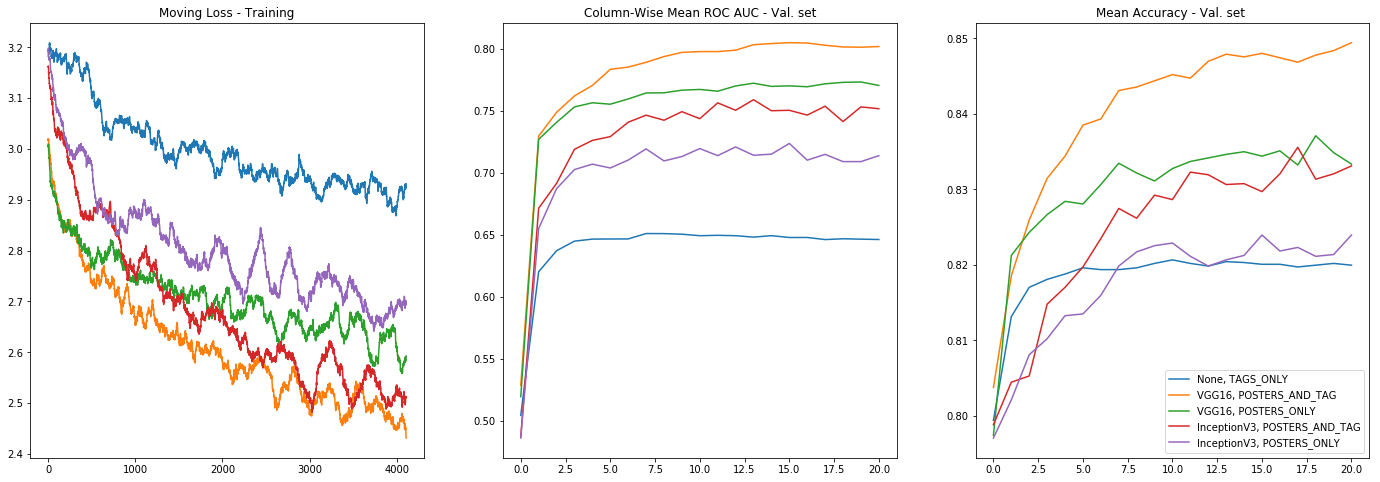

In [103]:
%matplotlib inline
import matplotlib.pyplot as plt

def plot_training_results():
    '''
    method plots the performance metrics that were gathered during trainin of the 5 models.
    Them metrics are
    - column-wise mean ROC-AUC
    - column-wise mean accuracy
    - moving losses from training with window size of 200
    '''
    
    plt.subplots(figsize=(24, 8))
    
    ax = plt.subplot(1, 3, 1)
    ax.set_title('Moving Loss - Training')
    for result in training_results:
        config = result['config']
        losses = result['validation_performances']['loss']
        moving_average_losses = []
        for i in range(len(losses)-200):
            moving_average_losses.append(np.mean(losses[i:i+200]))

        ax.plot(range(len(moving_average_losses)), moving_average_losses, 
                 label='{}, {}'.format(config['img_classifier_architecture'], config['model_type'].name))
        
    ax = plt.subplot(1, 3, 2)
    ax.set_title('Column-Wise Mean ROC AUC - Val. set')
    for result in training_results:
        config = result['config']
        performances = result['validation_performances']['performance']
        ax.plot(range(len(performances)), performances, 
                 label='{}, {}'.format(config['img_classifier_architecture'], config['model_type'].name))

        
    ax = plt.subplot(1, 3, 3)
    ax.set_title('Mean Accuracy - Val. set ')
    for result in training_results:
        config = result['config']
        mean_accuracy = result['validation_performances']['mean_accuracy']
        ax.plot(range(len(mean_accuracy)), mean_accuracy, 
                 label='{}, {}'.format(config['img_classifier_architecture'], config['model_type'].name))


    plt.legend()
    plt.show()
    
plot_training_results()

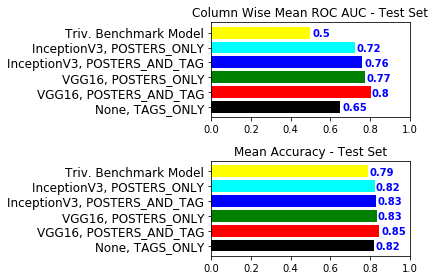

In [119]:
trivial_benchmark_roc_auc, _, trivial_benchmark_accuracy = calc_trivial_model_metrics()

# compute and plot performance metrics for each trained model on test set
test_performances = [result['performance'] for result in training_results]
test_performances.append(trivial_benchmark_roc_auc)

test_mean_accuracies = [result['mean_accuracy'] for result in training_results]
test_mean_accuracies.append(trivial_benchmark_accuracy)

model_ids = ['{}, {}'.format(result['config']['img_classifier_architecture'], result['config']['model_type'].name)for result in training_results]
model_ids.append('Triv. Benchmark Model')

ax = plt.subplot(2, 1, 1)
plt.title('Column Wise Mean ROC AUC - Test Set')
plt.barh(range(len(model_ids)), test_performances,color=['black', 'red', 'green', 'blue', 'cyan', 'yellow'])
plt.yticks(range(len(model_ids)), model_ids, fontsize=12)
for i, v in enumerate([round(elem, 2) for elem in test_performances]):
    ax.text(v+.01, i-.25, str(v), color='blue', fontweight='bold')
plt.xlim(right=1.0)

ax = plt.subplot(2, 1, 2)
plt.title('Mean Accuracy - Test Set')
plt.barh(range(len(model_ids)), test_mean_accuracies,color=['black', 'red', 'green', 'blue', 'cyan', 'yellow'])
plt.yticks(range(len(model_ids)), model_ids, fontsize=12)
for i, v in enumerate([round(elem, 2) for elem in test_mean_accuracies]):
    ax.text(v+.01, i-.25, str(v), color='blue', fontweight='bold')
plt.xlim(right=1.0)
plt.tight_layout()

In [105]:
best_model_path = None
best_performance = None
best_config = None
for result in training_results:
    if best_performance is None or best_performance < result['performance']:
        best_model_path = result['best_model_path']
        best_performance = result['performance']
        best_config = result['config']

print(best_config)
best_model = load_model(best_model_path)

{'img_classifier_architecture': 'VGG16', 'model_type': <ModelType.POSTERS_AND_TAG: 1>, 'img_size': (224, 224)}


In [106]:
def calc_opt_th(model, data):
    y_true, y_pred = calc_model_predictions(model, data, best_config)
    return calc_optimal_thresholds(y_true, y_pred)

optimal_thresholds = calc_opt_th(best_model, X_validation)
optimal_thresholds

[0.13781692,
 0.16628787,
 0.13531621,
 0.28532964,
 0.19370322,
 0.29322657,
 0.34664357,
 0.2373794]

In [107]:
def calc_predicted_labels(label_binarizer, y_pred_values, thresholds):
    y_predicted = (y_pred_values > thresholds).astype(int)
    return label_binarizer.inverse_transform(np.array([y_predicted]))[0]

def test_predicted_labels():
    lb = MultiLabelBinarizer()
    labels1 = ['class1', 'class2']
    labels2 = ['class1']
    lb.fit([labels1, labels2])
    predicted_labels = calc_predicted_labels(lb, np.array([0.2, 0.5]), np.array([0.1, 0.6]))
    assert len(predicted_labels) == len(labels2) == 1
    assert predicted_labels[0] == labels2[0]
    
test_predicted_labels()

In [108]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

def plot_img(img_file, real_labels, existing_labels, y_pred_values, predicted_labels):
    plt.figure(figsize=(6,8))
    img=mpimg.imread(os.path.join(posters_dir, img_file))

    ax1 = plt.subplot(2, 1, 1)
    plt.imshow(img)

    ax = plt.subplot(2, 1, 2)
    plt.barh(range(len(existing_labels)), list(y_pred_values))
    plt.yticks(range(len(existing_labels)), list(existing_labels), fontsize=12)
    ax.set_xlim(right=1.0)

    plt.gcf().text(0, 1.05, 'Labeled as {}'.format(real_labels), fontsize=18)
    plt.gcf().text(0, 1, 'Predicted {}'.format(predicted_labels), fontsize=18)
    plt.gcf().text(0, 0.95, os.path.basename(img_file), fontsize=10)
    plt.tight_layout()
    #plt.show()
    
    return plt

In [110]:
example_classifications_path = os.path.join('.', 'data', 'classification_examples')

if os.path.exists(example_classifications_path):
    shutil.rmtree(example_classifications_path)

if not os.path.exists(example_classifications_path):
    os.makedirs(example_classifications_path)

count = 0
for batch in batch_generator(X_test, best_config, distortion=False):
    predictions = best_model.predict(batch)
    for i in range(len(batch['genres'])):
        count += 1
        genres = batch['genres'][i]
        prediction = predictions[i]
        img_file = batch['image_files'][i]
        predicted_labels = calc_predicted_labels(genres_binarizer, prediction, optimal_thresholds)
        plt = plot_img(img_file, genres, genres_binarizer.classes_, prediction, predicted_labels)
        plt.savefig(os.path.join(example_classifications_path, img_file), bbox_inches='tight')
        plt.close()

<div style="display:flex">
<img src="data/classification_examples/4.jpg" alt="Drawing" style="width: 200px"/>
<img src="data/classification_examples/9.jpg" alt="Drawing" style="width: 200px;flex:1"/>
<img src="data/classification_examples/35.jpg" alt="Drawing" style="width: 200px;flex:2"/>
</div>

<div style="display:flex">
<img src="classification_examples/42.jpg" alt="Drawing" style="width: 200px"/>
<img src="classification_examples/89.jpg" alt="Drawing" style="width: 200px;flex:1"/>
<img src="classification_examples/192.jpg" alt="Drawing" style="width: 200px;flex:2"/>
</div>